In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def plot_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(losses, color='blue', lw=2)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training Loss Curve', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_solution(model, device):
    x = torch.linspace(-1, 1, 100).unsqueeze(1).to(device)
    t = torch.full((100, 1), 0.0).to(device)  # 设定 t=0

    with torch.no_grad():
        u_pred = model(t, x).cpu().numpy()  # 使用 .cpu() 将数据移回 CPU 以便绘图
    
    # 参考解 u(0,x) = -sin(πx)
    u_exact = -np.sin(np.pi * x.cpu().numpy())  

    plt.figure(figsize=(8, 5))
    plt.plot(x.cpu().numpy(), u_pred, label='Predicted Solution', color='red', lw=2)
    plt.plot(x.cpu().numpy(), u_exact, label='Exact Solution (Initial)', color='blue', lw=2, linestyle='dashed')
    plt.xlabel('x', fontsize=14)
    plt.ylabel('u(t=0, x)', fontsize=14)
    plt.title('Equation Solution at t=0', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [5]:
def plot_solution_3d(model, device):
    x = torch.linspace(-1, 1, 100).unsqueeze(1).to(device)
    t = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())
    
    x_flat = X.reshape(-1, 1)
    t_flat = T.reshape(-1, 1)

    with torch.no_grad():
        u_pred = model(t_flat, x_flat).cpu().numpy().reshape(100, 100)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X.cpu().numpy(), T.cpu().numpy(), u_pred, cmap='viridis')

    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('t', fontsize=12)
    ax.set_zlabel('u(t, x)', fontsize=12)
    ax.set_title('Solution on (x, t) Plane', fontsize=14)

    plt.show()


In [6]:
def plot_solution_contour(model, device):
    x = torch.linspace(-1, 1, 100).unsqueeze(1).to(device)
    t = torch.linspace(0, 1, 100).unsqueeze(1).to(device)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())

    # 扁平化网格数据
    x_flat = X.reshape(-1, 1)
    t_flat = T.reshape(-1, 1)

    with torch.no_grad():
        u_pred = model(t_flat, x_flat).cpu().numpy().reshape(100, 100)

    plt.figure(figsize=(8, 6))
    plt.contourf(X.cpu().numpy(), T.cpu().numpy(), u_pred, 100, cmap='viridis')
    plt.colorbar(label='u(t, x)')
    
    plt.xlabel('x', fontsize=12)
    plt.ylabel('t', fontsize=12)
    plt.title('Contour Plot of Solution', fontsize=14)
    
    plt.tight_layout()
    plt.show()


In [7]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(2, 8), nn.Tanh(),
            nn.Linear(8, 32), nn.Tanh(),
            nn.Linear(32, 64), nn.Tanh(),
            nn.Linear(64, 128), nn.Tanh(),nn.Dropout(0.4),
            nn.Linear(128, 64), nn.Tanh(),nn.Dropout(0.4),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 8), nn.Tanh(),
            nn.Linear(8, 1)
        )
    
    def forward(self, t, x):
        u = self.layer(torch.cat([t, x], dim=1))
        return u

In [8]:
def physics_loss(model, t, x):
    device = t.device  # 获取 t 的设备
    u = model(t, x)
    
    u_t = torch.autograd.grad(u, t, torch.ones_like(t, device=device), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(x, device=device), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x, device=device), create_graph=True)[0]
    
    # 计算物理损失
    f = (u_t + u * u_x - (0.01 / torch.pi) * u_xx).pow(2).mean()
    return f


In [9]:
def boundary_loss(model, t, x_left, x_right):
    device = t.device
    
    u_left = model(t, x_left)
    u_right = model(t, x_right)
    
    # 返回边界损失
    return u_left.pow(2).mean() + u_right.pow(2).mean()


In [10]:
def initial_loss(model, x):
    t_0 = torch.zeros_like(x).to(x.device)  # 确保 t_0 在相同的设备上
    u_init = model(t_0, x)
    u_exact = -torch.sin(torch.pi * x).to(x.device)  # 确保 u_exact 在相同的设备上
    return (u_init - u_exact).pow(2).mean()


In [11]:

def train(model, optimizer, num_epochs, device):
    losses = []
    model.to(device)  # 将模型移到指定设备（GPU 或 CPU）
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # 创建训练数据并移动到设备
        t = torch.rand(4000, 1, requires_grad=True).to(device)
        x = torch.rand(4000, 1, requires_grad=True).to(device) * 2 - 1  # x ∈ [-1, 1]

        f_loss = physics_loss(model, t, x)

        # 创建边界条件数据并移动到设备
        t_bc = torch.rand(500, 1).to(device)
        x_left = -torch.ones(500, 1).to(device)
        x_right = torch.ones(500, 1).to(device)
        bc_loss = boundary_loss(model, t_bc, x_left, x_right)

        # 创建初始条件数据并移动到设备
        x_ic = torch.rand(1000, 1) * 2 - 1
        x_ic = x_ic.to(device)  # 移动到设备
        ic_loss = initial_loss(model, x_ic)

        loss = f_loss + bc_loss + ic_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return losses


/home/wangz/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.5072664022445679
Epoch 100, Loss: 0.4370250999927521
Epoch 200, Loss: 0.4180256426334381
Epoch 300, Loss: 0.33157971501350403
Epoch 400, Loss: 0.2539176046848297
Epoch 500, Loss: 0.19266892969608307
Epoch 600, Loss: 0.16943864524364471
Epoch 700, Loss: 0.1642482578754425
Epoch 800, Loss: 0.16072754561901093
Epoch 900, Loss: 0.15520745515823364
Epoch 1000, Loss: 0.14951953291893005
Epoch 1100, Loss: 0.1438114047050476
Epoch 1200, Loss: 0.1433076709508896
Epoch 1300, Loss: 0.1416221261024475
Epoch 1400, Loss: 0.13396047055721283
Epoch 1500, Loss: 0.1348639279603958
Epoch 1600, Loss: 0.1253369003534317
Epoch 1700, Loss: 0.12686346471309662
Epoch 1800, Loss: 0.11606603860855103
Epoch 1900, Loss: 0.1142619401216507
Epoch 2000, Loss: 0.11305142939090729
Epoch 2100, Loss: 0.10913968086242676
Epoch 2200, Loss: 0.10981319844722748
Epoch 2300, Loss: 0.10130535811185837
Epoch 2400, Loss: 0.09908527135848999
Epoch 2500, Loss: 0.0956612303853035
Epoch 2600, Loss: 0.0913820341229438

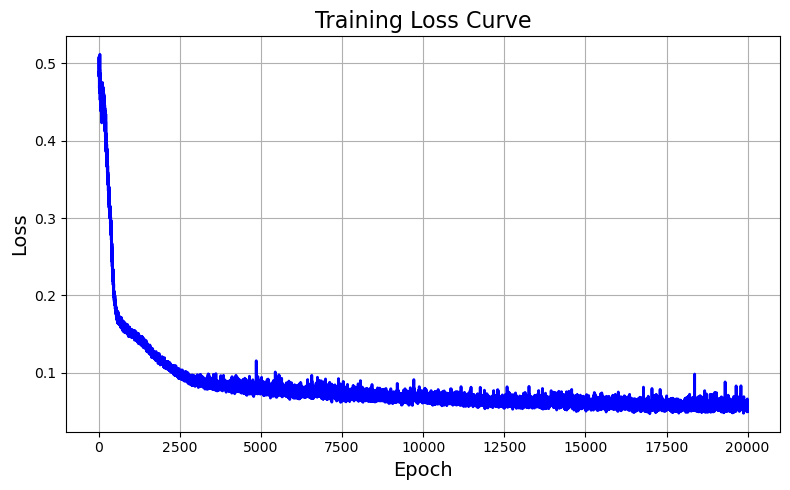

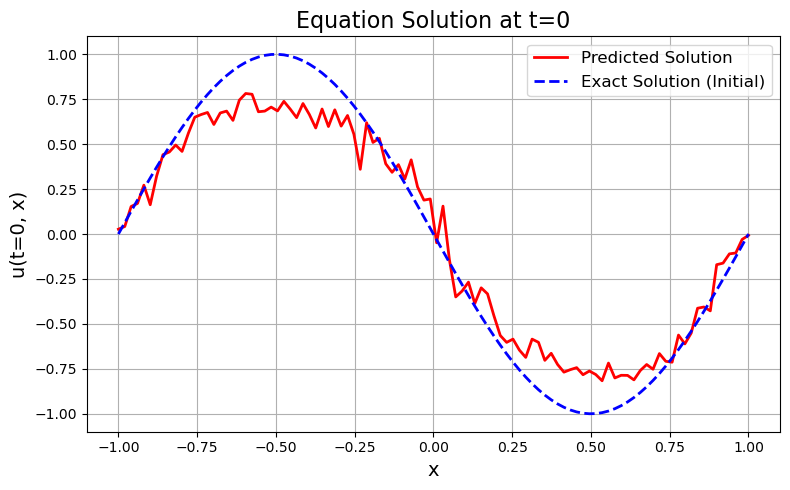

/home/wangz/anaconda3/lib/python3.12/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


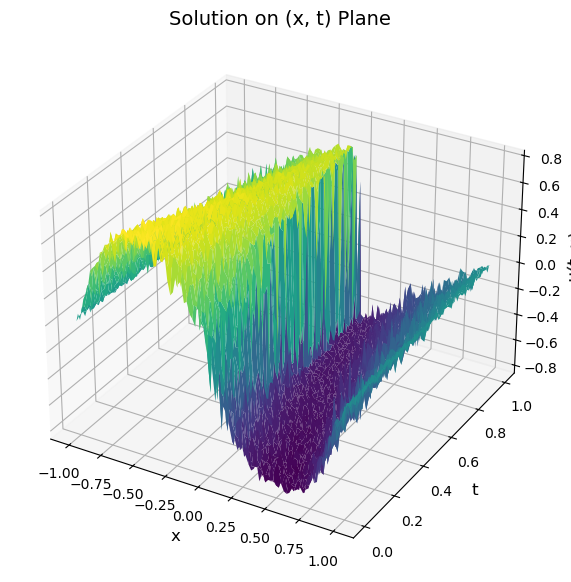

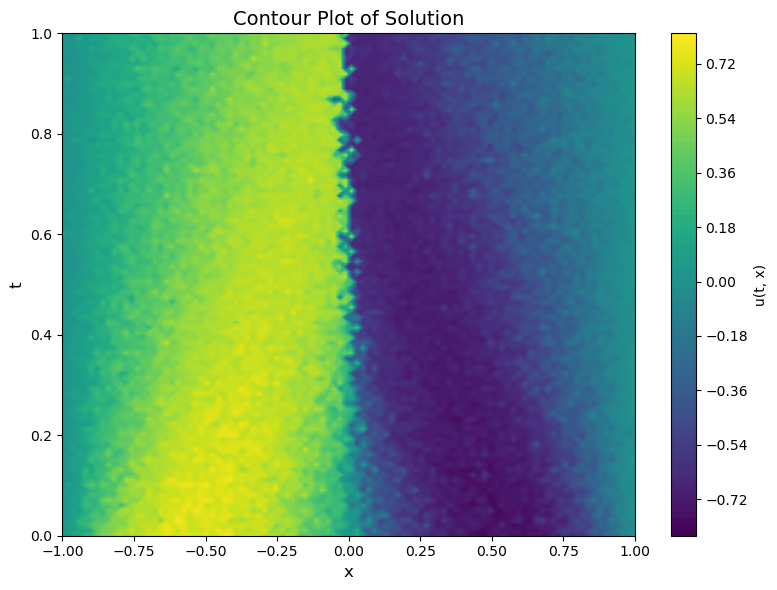

In [12]:
model = PINN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = train(model, optimizer, num_epochs=20000, device=device)

plot_loss(losses)


plot_solution(model, device)  # 传递 device
plot_solution_3d(model, device)  # 传递 device
plot_solution_contour(model, device)  # 传递 device